Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [8]:
!unzip "/content/gdrive/MyDrive/DeepLearning/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
import os
root_path = '/content/gdrive/My Drive/Melanoma_exercise/Data/'
data_dir_train = pathlib.Path(root_path+"Train")
data_dir_test = pathlib.Path(root_path+'Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

32
32


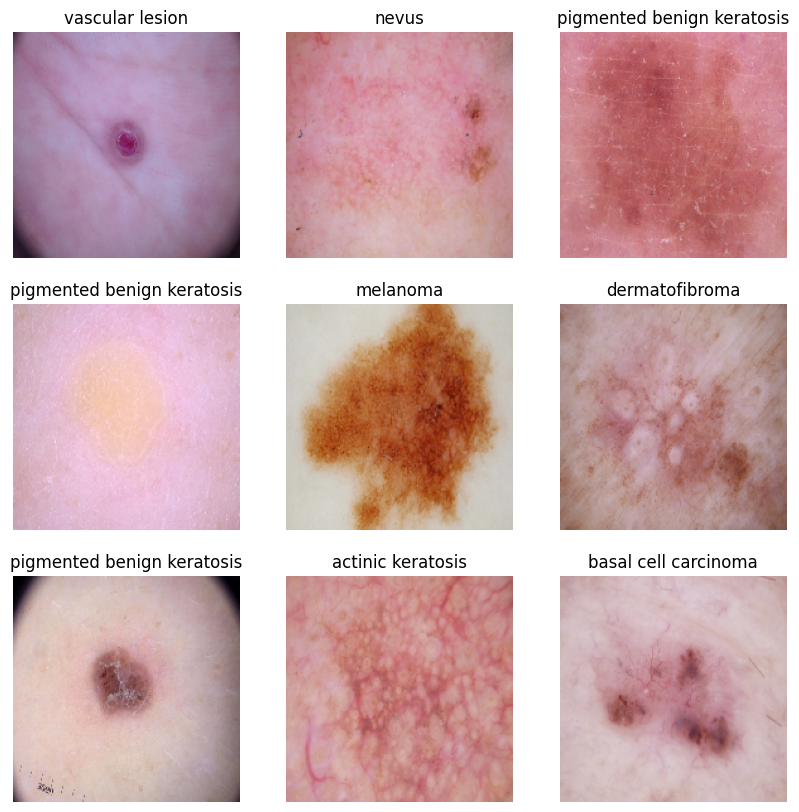

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

Determine number of images in each class

In [17]:
def number_of_images(directory):
  # count number of image in each classes
  count= []
  for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
      count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
  # name of the classes
  sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
  # return dataframe with image count and class.
  return pd.DataFrame(list(zip(sub_directory,count)),columns =['Image Class', 'Number of Images']).sort_values(by='Number of Images', ascending=False).reset_index(drop=True)

number_of_images(data_dir_train)

,Image Class,Number of Images
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
### Your code goes here

### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.5),


  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.25),

  layers.Dense(128, activation='relu'),

  layers.Dropout(0.25),

  layers.Dense(64, activation='relu'),

  layers.Dropout(0.25),

  layers.Dense(num_classes,activation='softmax')
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,360,265 (31.89 MB)

 Trainable params: 8,360,265 (31.89 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Reduce learning rate when val_accuracy has stopped improving.

In [22]:
lr_ctrl = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-7)

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved

In [23]:
checkpoint = ModelCheckpoint("model.h5.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

Stop training when a monitored metric has stopped improving.

In [24]:

early_stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Train the model

In [25]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_ctrl, checkpoint, early_stop]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1730 - loss: 2.1530
Epoch 1: val_accuracy improved from -inf to 0.20582, saving model to model.h5.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.1731 - loss: 2.1521 - val_accuracy: 0.2058 - val_loss: 2.0322 - learning_rate: 0.0010
Epoch 2/40
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1787 - loss: 2.0330
Epoch 2: val_accuracy improved from 0.20582 to 0.34676, saving model to model.h5.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.1796 - loss: 2.0324 - val_accuracy: 0.3468 - val_loss: 1.9221 - learning_rate: 0.0010
Epoch 3/40
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2459 - loss: 1.9377
Epoch 3: val_accuracy improved from 0.34676 to 0.38479, saving model to model.h5.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.2462 - loss: 1.9375 - val_accuracy: 0.3848 - val_loss: 1.7326 - learning_rate: 0.0010
Epoch 4/40
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3395 - los

### Visualizing training results

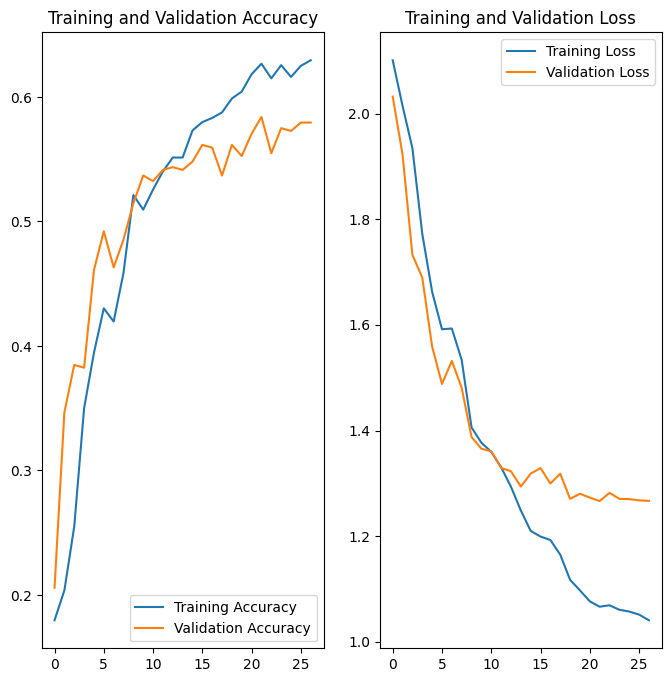

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(early_stop.stopped_epoch+1)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
from keras.models import load_model

if pathlib.Path('/content/model.h5.kears').is_file():
  # if model is available at the current runtime
  model_1 = load_model('model.h5')
  print('INFO: Temporary stored "model.h5" has been loaded successfully.')
  print('WARNING: Prevent losing the temporary "model.h5" file. You must download and save the file at "gdrive/MyDrive", so it can be loaded later from this location in the event of unintended runtime disconnection !!')
elif pathlib.Path('/content/gdrive/MyDrive/Melanoma_exercise/model.h5.keras').is_file():
  # load the serialized weights from
  model_1 = load_model(pathlib.Path('/content/gdrive/MyDrive/Melanoma_exercise/model.h5.keras'))
  print('INFO: "gdrive/MyDrive/model.h5" file has been loaded successfully.')
else:
  raise Exception('FileNotFoundError: Your last runtime was disconnected and hence the current runtime could not retrieve the previously created temporary HDF5 model file. Maybe you have missed to download/save the previously generated "model.h5" file at your directory "/gdrive/MyDrive" to reuse it in the event of unintended runtime diconnection !!')
train_loss, train_accuracy = model_1.evaluate(train_ds, verbose=1,)
validation_loss, validation_accuracy = model_1.evaluate(val_ds, verbose=1)

print('Train Accuracy: ', train_accuracy)
print('Validation Accuracy: ',validation_accuracy)
print('Train Loss: ',train_loss)
print('Validation Loss', validation_loss)

INFO: "gdrive/MyDrive/model.h5" file has been loaded successfully.
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6323 - loss: 0.9886
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6335 - loss: 1.1971
Train Accuracy:  0.6411830186843872
Validation Accuracy:  0.5838926434516907
Train Loss:  0.958903968334198
Validation Loss 1.2664859294891357


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model built or saved is significantly better than a random guessor as the train accuracy is 64%.

Though both the train and validation accuracies are slightly different but they are considerably very low. Hence, the estimated model seemed to underfit the train set.

We will try with data augumentation strategy with flip, rotate, contrast, brightness, zoom, saturation etc to assess if it improves the overall model performance

### Write your findings here

In [28]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow import keras
from tensorflow.keras import layers

# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    #layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    #layers.RandomCrop(img_height,img_width),
  ]
)


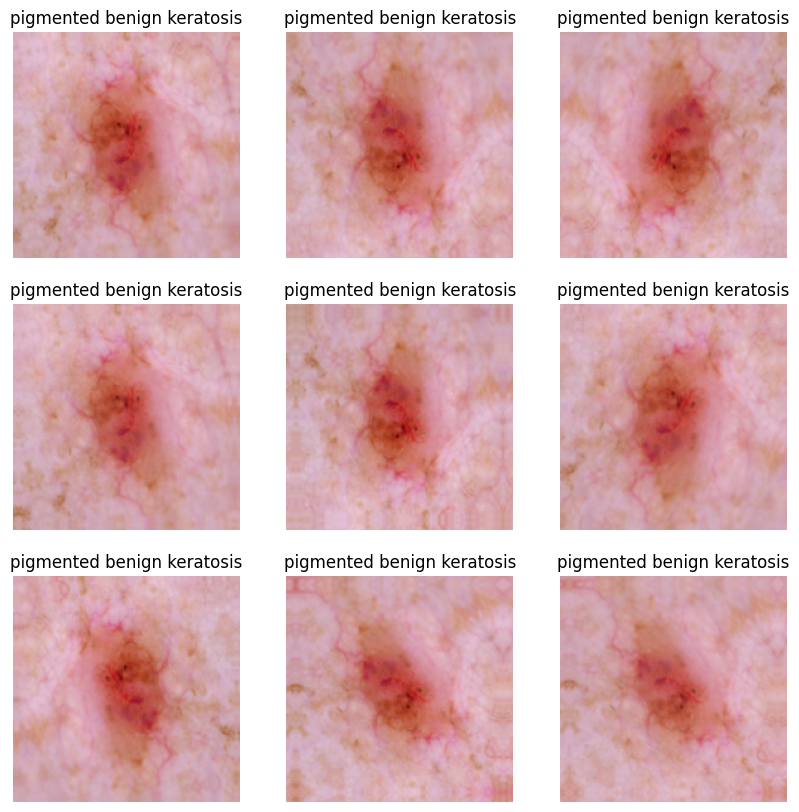

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[2]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

## You can use Dropout layer if there is an evidence of overfitting in your findings

model_augmen = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])







### Compiling the model

In [31]:
## Your code goes here

model_augmen.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

Call backs for Augmen model

In [32]:
lr_ctrl_augmen = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-7)
checkpoint_augmen = ModelCheckpoint("model_augmen.h5.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
early_stop_augmen = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Training the model

In [33]:
## Your code goes here, note: train your model for 20 epochs
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_ctrl_augmen, checkpoint_augmen, early_stop_augmen]
)

Epoch 1/40
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6322 - loss: 1.0389
Epoch 1: val_accuracy improved from -inf to 0.57942, saving model to model_augmen.h5.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.6318 - loss: 1.0394 - val_accuracy: 0.5794 - val_loss: 1.2671 - learning_rate: 2.4300e-06
Epoch 2/40
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6326 - loss: 1.0244
Epoch 2: val_accuracy did not improve from 0.57942
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6323 - loss: 1.0252 - val_accuracy: 0.5772 - val_loss: 1.2682 - learning_rate: 2.4300e-06
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6350 - loss: 1.0249
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.

Epoch 3: val_accuracy did not improve from 0.57942
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6347 - loss: 1.0254 - val_accuracy: 0.5749 - val_loss: 1.2690 - learning_rate: 2.4300e-06
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 

### Visualizing the results

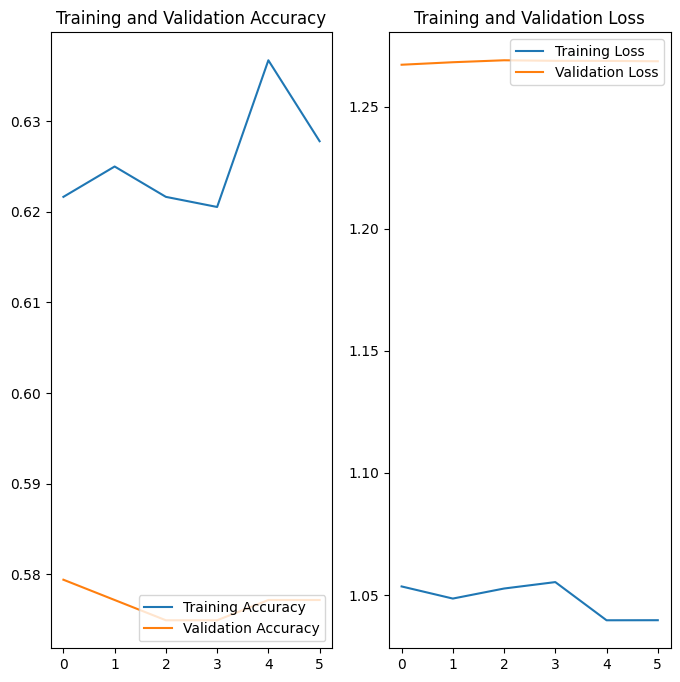

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(early_stop_augmen.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Interpretation



We increased the diversity among the individual training images when we added the data augmentation layer in the model architecture. This prevented it from detecting any prominent patterns in those images over subsequent epochs to better separate them between classes. Hence the training accuracy is significantly lower, underfitting the images belonging to the majority class. Might be the need is to train it for much larger number of epochs before invoking the early stopping scheme (monitoring the improvement in the validation accuracy)

We observed fluctuations in the validation loss with reduction in the training loss over subsequent epochs, as the model seemed to jump over the minima frequently as it experienced much higher variability with the augmented training images. Recommendation is to start with a much lower learning rate or reduce the learning rate at few earlier epochs to ensure smooth and slow convergence, with training the underlying algorithm over large number of epochs to achieve requisite performance

In [35]:

from keras.models import load_model

if pathlib.Path('/content/model_augmen.h5.keras').is_file():
  # if model is available at the current runtime
  model_1 = load_model('model_augmen.h5')
  print('INFO: Temporary stored "model_augmen.h5" has been loaded successfully.')
  print('WARNING: Prevent losing the temporary "model_augmen.h5" file. You must download and save the file at "gdrive/MyDrive", so it can be loaded later from this location in the event of unintended runtime disconnection !!')
elif pathlib.Path('/content/gdrive/MyDrive/Melanoma_exercise/model_augmen.h5.keras').is_file():
  # load the serialized weights from
  model_1 = load_model(pathlib.Path('/content/gdrive/MyDrive/Melanoma_exercise/model_augmen.h5.keras'))
  print('INFO: "gdrive/MyDrive/model_augmen.h5" file has been loaded successfully.')
else:
  raise Exception('FileNotFoundError: Your last runtime was disconnected and hence the current runtime could not retrieve the previously created temporary HDF5 model file. Maybe you have missed to download/save the previously generated "model_augmen.h5" file at your directory "/gdrive/MyDrive" to reuse it in the event of unintended runtime diconnection !!')
train_loss, train_accuracy = model_1.evaluate(train_ds, verbose=1,)
validation_loss, validation_accuracy = model_1.evaluate(val_ds, verbose=1)

print('Train Accuracy: ', train_accuracy)
print('Validation Accuracy: ',validation_accuracy)
print('Train Loss: ',train_loss)
print('Validation Loss', validation_loss)

INFO: "gdrive/MyDrive/model_augmen.h5" file has been loaded successfully.


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6403 - loss: 0.9591
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6260 - loss: 1.1954
Train Accuracy:  0.6450892686843872
Validation Accuracy:  0.5794183611869812
Train Loss:  0.9447640180587769
Validation Loss 1.2671345472335815


The model built or saved is  better than a random guessor as the train accuracy is just 65%.

The validation accuracy is low compared to test accuray. Hence, the estimated model seemed to overfit the train set.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
## Your code goes here.


number_of_images(data_dir_train)

,Image Class,Number of Images
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis has 77 training examples

#### - Which classes dominate the data in terms proportionate number of samples?

pigmented benign keratosis with 462 training images
melanoma with 438 training images
basal cell carcinoma with 376 training images
nevus with 357 training images





#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:

path_to_training_dataset="/content/gdrive/My Drive/Melanoma_exercise/Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB945C7DCF0>: 100%|██████████| 500/500 [00:19<00:00, 26.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB94472A560>: 100%|██████████| 500/500 [00:21<00:00, 23.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB945C08F40>: 100%|██████████| 500/500 [00:19<00:00, 25.76 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7CB945D6CFA0>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7CB945DF6110>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB956267F10>: 100%|██████████| 500/500 [00:21<00:00, 23.34 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CB945E60340>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB942695E70>: 100%|██████████| 500/500 [00:19<00:00, 25.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma_exercise/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB9561BA470>: 100%|██████████| 500/500 [00:20<00:00, 24.41 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_2aee3e22-78ba-4eec-8a95-cacb8f553c8a.jpg',
 '/content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_54153d43-5bfd-4c2f-b136-32cc930e4f1b.jpg',
 '/content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029210.jpg_2950d6f4-6063-4693-ace7-b25a7d3d26b1.jpg',
 '/content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_82fd5d53-c08c-4da9-9925-c0e6504b5901.jpg',
 '/content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_d85ca5d5-67c7-485f-8247-fd04956ea874.jpg',
 '/content/gdrive/My Drive/Melanoma_exercise/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_3c53f3aa-2578-46f7-8175-6ba22662ab5

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [46]:

df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
data_dir_train="/content/gdrive/My Drive/Melanoma_exercise/Data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [50]:
model_augmentor = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
model_augmentor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
)

In [52]:
lr_ctrl_augmentor = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-7)
checkpoint_augmentor = ModelCheckpoint("model_augmentor.h5.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
early_stop_augmentor = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### **Todo:**  Train your model

In [53]:

epochs = 50
history = model_augmentor.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_ctrl_augmentor, checkpoint_augmentor, early_stop_augmentor]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.1485 - loss: 2.1724
Epoch 1: val_accuracy improved from -inf to 0.31180, saving model to model_augmentor.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 324ms/step - accuracy: 0.1488 - loss: 2.1717 - val_accuracy: 0.3118 - val_loss: 1.7520 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2505 - loss: 1.8440
Epoch 2: val_accuracy improved from 0.31180 to 0.34967, saving model to model_augmentor.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 274ms/step - accuracy: 0.2506 - loss: 1.8440 - val_accuracy: 0.3497 - val_loss: 1.7644 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3346 - loss: 1.7252
Epoch 3: val_accuracy improved from 0.34967 to 0.40683, saving model to model_augmentor.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 280ms/step - accuracy: 0.3346 - loss: 1.7251 - val_accuracy: 0.4068 - val_loss: 1.5435 - learning_rate: 0.0010
Epoch 4/50
169/1

#### **Todo:**  Visualize the model results

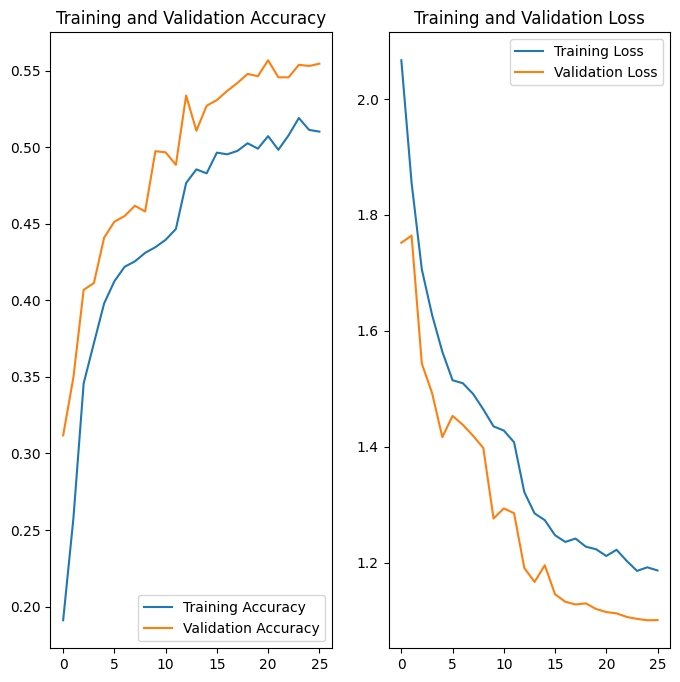

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(early_stop_augmentor.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
from keras.models import load_model

if pathlib.Path('/content/model_augmentor.h5').is_file():
  # if model is available at the current runtime
  model_1 = load_model('model_augmentor.h5')
  print('INFO: Temporary stored "model_augmentor.h5" has been loaded successfully.')
  print('WARNING: Prevent losing the temporary "model_augmentor.h5" file. You must download and save the file at "gdrive/MyDrive", so it can be loaded later from this location in the event of unintended runtime disconnection !!')
elif pathlib.Path('/content/gdrive/MyDrive/Melanoma_exercise/model_augmentor.h5.keras').is_file():
  # load the serialized weights from
  model_1 = load_model(pathlib.Path('/content/gdrive/MyDrive/Melanoma_exercise/model_augmentor.h5.keras'))
  print('INFO: "gdrive/MyDrive/model_augmentor.h5" file has been loaded successfully.')
else:
  raise Exception('FileNotFoundError: Your last runtime was disconnected and hence the current runtime could not retrieve the previously created temporary HDF5 model file. Maybe you have missed to download/save the previously generated "model_augmentor.h5" file at your directory "/gdrive/MyDrive" to reuse it in the event of unintended runtime diconnection !!')
train_loss, train_accuracy = model_1.evaluate(train_ds, verbose=1,)
validation_loss, validation_accuracy = model_1.evaluate(val_ds, verbose=1)

print('Train Accuracy: ', train_accuracy)
print('Validation Accuracy: ',validation_accuracy)
print('Train Loss: ',train_loss)
print('Validation Loss', validation_loss)

INFO: "gdrive/MyDrive/model_augmentor.h5" file has been loaded successfully.
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.5386 - loss: 1.1100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.5667 - loss: 1.0569
Train Accuracy:  0.5328264236450195
Validation Accuracy:  0.5567928552627563
Train Loss:  1.11603581905365
Validation Loss 1.1149059534072876


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



According to results class rebalance did not improve the results. Model Performance degraded after adding the rebalance